In [62]:
import pandas as pd, datetime as dt, matplotlib.pyplot as plt, numpy as np, streamlit as st, os, sys, nest_asyncio
import py_vollib_vectorized

from py_vollib.black_scholes import black_scholes
from py_vollib.black_scholes.greeks.analytical import delta
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes.greeks.analytical import delta

import datetime, warnings
%matplotlib inline 

In [63]:
# importing functions from the code base
base_path = os.path.abspath(os.path.join('..'))
print(base_path)
if base_path not in sys.path:
    sys.path.append(base_path)
    
import src.api as api

/Users/marcfiani/Documents/projects/active/crypto_option_dashboard


***
## 1) Enter Inputs

In [64]:
underlying = "BTC"  # Values can be 'BTC' or 'ETH'
desired_option_type = "Call"  # Values can be 'Call' or 'Put'

***
## 2) Identify the month-end option of the correct type for the chosen underlying

In [65]:
nest_asyncio.apply()
instruments = api.get_instruments(currency=underlying, kind="option", expired=False)
instruments.head(2)

,tick_size,taker_commission,strike,settlement_period,settlement_currency,rfq,quote_currency,option_type,min_trade_amount,maker_commission,...,instrument_name,instrument_id,expiration_timestamp,creation_timestamp,counter_currency,contract_size,block_trade_commission,base_currency,creation_time,expiration_time
0,0.0005,0.0003,30000.0,month,BTC,False,BTC,call,0.1,0.0003,...,BTC-24JUN22-30000-C,125666,1656057600000,1627994072000,USD,1.0,0.00015,BTC,2021-08-03 07:34:32,2022-06-24 03:00:00
1,0.0005,0.0003,45000.0,month,BTC,False,BTC,put,0.1,0.0003,...,BTC-25MAR22-45000-P,125665,1648195200000,1628197380000,USD,1.0,0.00015,BTC,2021-08-05 16:03:00,2022-03-25 03:00:00


#### 2)a) Identify what month we will be on in 3 days time

In [66]:
desired_month = (dt.datetime.now() + dt.timedelta(days=3)).month
datetime_object = datetime.datetime.strptime(str(desired_month), "%m")
month_name = datetime_object.strftime("%B")

print(f"In 3 days time we will be in {month_name}")

In 3 days time we will be in March


#### 2)b) Get the last expiry for that month  (that expiry will be on the last Friday of the month)

In [67]:
# Get the last option expiring on that month
expiry_dates = instruments.expiration_time.unique()
expiry_months = expiry_dates.astype('datetime64[M]').astype(int) % 12 + 1

month_end_expiry = np.datetime64(dt.datetime.now())

for i in range(0, len(expiry_dates)):
    if expiry_months[i] == desired_month and expiry_dates[i] > month_end_expiry:
        month_end_expiry =  expiry_dates[i]

print(month_end_expiry)

2023-03-31T03:00:00.000000000


In [68]:
expiry_times = instruments.expiration_time.unique()
expiry_times.sort()
expiry_times = pd.to_datetime(expiry_times)

In [69]:
current_year = dt.datetime.now().year
is_month_end_expiry_assigned = False

for expiry in expiry_times:
    if expiry.month == desired_month:
        if expiry.year != current_year and is_month_end_expiry_assigned:
            continue
        month_end_expiry = expiry
        is_month_end_expiry_assigned = True

#### 2)c) Get current spot (there are much better ways to do this)

In [70]:
temp = dt.datetime.now()
today_dt = dt.datetime(year=temp.year, month=temp.month, day=temp.day, hour=temp.hour, minute=temp.minute)

ts_today = today_dt.timestamp() * 1000
spot_ohlcv = api.get_historical_data(ts_today, ts_today, underlying + "-PERPETUAL", "1D")

spot = (spot_ohlcv['open'][0] + spot_ohlcv['close'][0] + spot_ohlcv['high'][0] + spot_ohlcv['low'][0]) / 4

print(spot)

Exception ignored in: <function BaseEventLoop.__del__ at 0x1057a2f70>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.1_8/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 681, in __del__
    _warn(f"unclosed event loop {self!r}", ResourceWarning, source=self)
Exception ignored in: <socket.socket fd=85, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.1_8/Frameworks/Python.framework/Versions/3.9/lib/python3.9/inspect.py", line 2931, in _bind
    parameters = iter(self.parameters.values())
Exception ignored in: <socket.socket fd=86, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.1_8/Frameworks/Python.framework/Versions/3.9/lib/python3.9/inspect.py", line 2931, in _bind
    parameters = iter(self.parameters.values())


#### 2)d) Find the closest strike from the current spot among the ones available

In [ ]:
desired_option_type = desired_option_type.lower()

strikes = instruments.loc[instruments['expiration_time'] == month_end_expiry].loc[instruments['option_type'] == desired_option_type].strike.unique()
desired_strike = min(strikes, key=lambda x:abs(x-spot))
desired_strike = 40000.0

print(desired_strike)

40000.0


#### 2)e) Isolate the data related to the option we are looking to backtest

In [ ]:
instrument_data = instruments.loc[(instruments.expiration_time == month_end_expiry) 
                                  & (instruments.option_type == desired_option_type) 
                                  & (instruments.strike == desired_strike)]

instrument_data

,tick_size,taker_commission,strike,settlement_period,settlement_currency,rfq,quote_currency,option_type,min_trade_amount,maker_commission,...,instrument_name,instrument_id,expiration_timestamp,creation_timestamp,counter_currency,contract_size,block_trade_commission,base_currency,creation_time,expiration_time
198,0.0005,0.0003,40000.0,month,BTC,False,BTC,call,0.1,0.0003,...,BTC-25MAR22-40000-C,125019,1648195200000,1627994072000,USD,1.0,0.00015,BTC,2021-08-03 07:34:32,2022-03-25 03:00:00


In [ ]:
instrument_data

,tick_size,taker_commission,strike,settlement_period,settlement_currency,rfq,quote_currency,option_type,min_trade_amount,maker_commission,...,instrument_name,instrument_id,expiration_timestamp,creation_timestamp,counter_currency,contract_size,block_trade_commission,base_currency,creation_time,expiration_time
198,0.0005,0.0003,40000.0,month,BTC,False,BTC,call,0.1,0.0003,...,BTC-25MAR22-40000-C,125019,1648195200000,1627994072000,USD,1.0,0.00015,BTC,2021-08-03 07:34:32,2022-03-25 03:00:00


***
## 3) Fetch Historical Data from the Deribit API

#### 3)a) Get data of both spot and option historical levels

In [ ]:
ts_creation = dt.datetime.fromtimestamp(instrument_data["creation_timestamp"].values[0]/1000).replace(second = 0, microsecond = 0).timestamp() * 1000
ts_start = int((dt.datetime.now() + dt.timedelta(days=-60)).timestamp() * 1000)
ts_expiration = dt.datetime.fromtimestamp(instrument_data["expiration_timestamp"].values[0]/1000).replace(second = 0, microsecond = 0).timestamp() * 1000

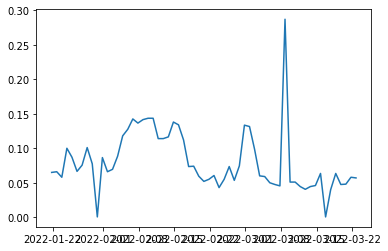

/usr/local/Cellar/python@3.9/3.9.1_8/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py:681: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  _warn(f"unclosed event loop {self!r}", ResourceWarning, source=self)


In [ ]:
time_period = '1D'
option_data = api.get_historical_data(ts_start,
                                      ts_expiration,
                                      instrument_data["instrument_name"].iloc[0],
                                      time_period)
plt.plot(option_data['timestamp'], option_data['close'])

In [ ]:
instrument_data["instrument_name"].iloc[0]

'BTC-25MAR22-40000-C'

In [ ]:
option_data

,volume,ticks,status,open,low,high,cost,close,timestamp
0,51.2,1642809600000,ok,0.0865,0.0650,0.1065,3.96970,0.0650,2022-01-21 19:00:00
1,3.2,1642896000000,ok,0.0760,0.0660,0.0760,0.22980,0.0660,2022-01-22 19:00:00
2,4.0,1642982400000,ok,0.0725,0.0580,0.0725,0.25750,0.0580,2022-01-23 19:00:00
3,62.3,1643068800000,ok,0.1200,0.1000,0.1200,6.17115,0.1000,2022-01-24 19:00:00
4,35.3,1643155200000,ok,0.1025,0.0820,0.1025,3.32220,0.0870,2022-01-25 19:00:00
...,...,...,...,...,...,...,...,...,...
56,1657.9,1647648000000,ok,0.0400,0.0400,0.5565,96.57087,0.0635,2022-03-18 19:00:00
57,1175.4,1647734400000,ok,0.0005,0.0005,0.0485,62.77211,0.0475,2022-03-19 19:00:00
58,2007.3,1647820800000,ok,0.0005,0.0005,0.0480,81.15765,0.0480,2022-03-20 19:00:00
59,708.8,1647907200000,ok,0.0480,0.0480,0.5595,93.25920,0.0580,2022-03-21 19:00:00


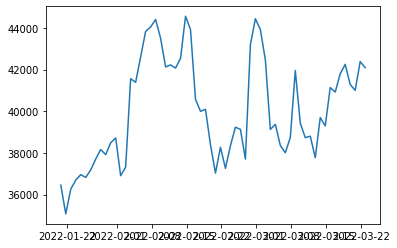

In [ ]:
# For BTC the underlying will be 'BTC-PERPETUAL' while for ETH it will be 'ETH-PERPETUAL'
spot_data = api.get_historical_data(option_data.timestamp[0].timestamp() * 1000,
                                    ts_expiration,
                                    underlying + "-PERPETUAL",
                                    time_period)
plt.plot(spot_data['timestamp'], spot_data['close'])

#### Clean up option_data to remove stale prices

In [ ]:
option_data[56:].head()

,volume,ticks,status,open,low,high,cost,close,timestamp
56,1657.9,1647648000000,ok,0.0400,0.0400,0.5565,96.57087,0.0635,2022-03-18 19:00:00
57,1175.4,1647734400000,ok,0.0005,0.0005,0.0485,62.77211,0.0475,2022-03-19 19:00:00
58,2007.3,1647820800000,ok,0.0005,0.0005,0.0480,81.15765,0.0480,2022-03-20 19:00:00
59,708.8,1647907200000,ok,0.0480,0.0480,0.5595,93.25920,0.0580,2022-03-21 19:00:00
60,136.2,1647993600000,ok,0.0575,0.0425,0.0575,7.67275,0.0570,2022-03-22 19:00:00


In [ ]:
if desired_option_type == 'call' or desired_option_type == 'Call':
    option_type = 'c'
else:
    option_type = 'p'
    
r = 0.01
qty = 1
mult = 1

In [ ]:
warnings.filterwarnings("error")

implied_vols = np.zeros(len(option_data.index))
deltas = np.zeros(len(option_data.index))

option_pnls = np.zeros(len(option_data.index))
spot_pnls = np.zeros(len(option_data.index))
combined_pnls = np.zeros(len(option_data.index))
cum_pnl = np.zeros(len(option_data.index))

option_pos = np.zeros(len(option_data.index))
spot_pos = np.zeros(len(option_data.index))

is_delta_hedged = True

for i in range(0, len(option_data.index)):
    is_invalid_implied_vol = False
    days_to_expiry = (dt.datetime.fromtimestamp(ts_expiration / 1000) - dt.datetime.fromtimestamp(option_data['ticks'][i] / 1000)).days
    
    try:
        implied_vols[i] = implied_volatility(price=option_data['close'][i] * spot_data['close'][i],
                                             S=spot_data['close'][i],
                                             K=desired_strike,
                                             t=days_to_expiry/365,
                                             r=r,
                                             flag=option_type, 
                                             return_as="numpy")
    except:
        is_invalid_implied_vol = True
        print(i)
        if i == 0:
            implied_vols[0] = 0.70
        else:
            implied_vols[i] = implied_vols[i-1]
    if i>0 and implied_vols[i] > 2* implied_vols[i-1]:
            implied_vols[i]=1.1*implied_vols[i-1]
    if i>0 and implied_vols[i] < 0.5* implied_vols[i-1]:
        implied_vols[i]=0.9*implied_vols[i-1]      
    
    if option_data['volume'][i] == 0.0 or is_invalid_implied_vol:
        option_data.loc[i, 'close'] = black_scholes(flag=option_type, 
                                                    S=spot_data['close'][i],
                                                    K=desired_strike,
                                                    t=days_to_expiry/365,
                                                    r=r,
                                                    sigma=implied_vols[i],
                                                    return_as='numpy')[0] / spot_data['close'][i]
    
    deltas[i] = delta(option_type, spot_data['close'][i], desired_strike, days_to_expiry / 365, r, implied_vols[i])
    
    option_pos[i] = qty
    spot_pos[i] = ( deltas[i] * option_pos[i] * mult ) * is_delta_hedged
    
    if i > 0:
        option_pnls[i] = (option_data['close'][i]*spot_pnl[i] - option_data['close'][i-1]*spot_pnl[i-1]) * option_pos[i-1] * mult
        
        spot_pnls[i] = (spot_data['close'][i] - spot_data['close'][i-1]) * spot_pos[i-1]
        
        combined_pnls[i] = option_pnls[i] + spot_pnls[i]
        
        cum_pnl[i] += combined_pnls[i]
        
warnings.filterwarnings("default")

SyntaxError: can't use starred expression here (833075810.py, line 38)

In [ ]:
option_data['volume'][10]

435.1

In [ ]:
option_data['close'][12]

0.0695

In [ ]:
option_data['close'][7]

0.101

In [ ]:
spot_data['close'][13]

41565.5

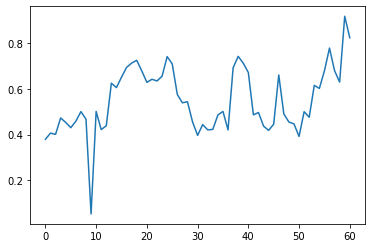

In [ ]:
plt.plot(deltas)

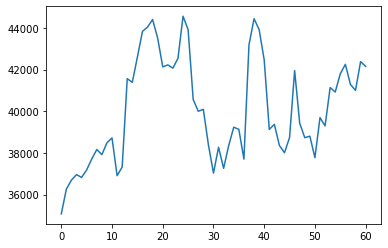

In [ ]:
plt.plot(spot_data['close'])

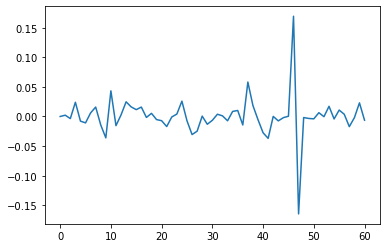

In [ ]:
plt.plot(option_pnls)

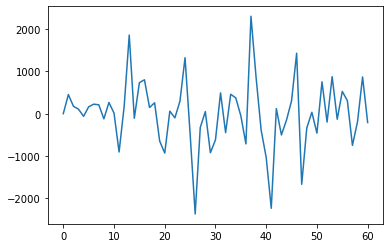

In [ ]:
plt.plot(spot_pnls)

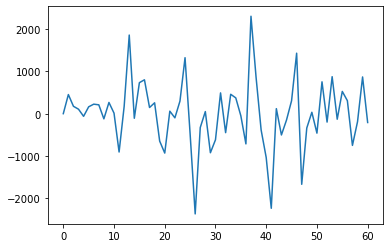

In [ ]:
plt.plot(combined_pnls)

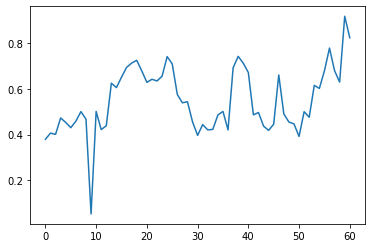

In [ ]:
plt.plot(spot_pos)

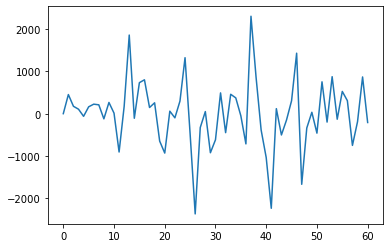

In [ ]:
plt.plot(cum_pnl)

In [ ]:
option_data[56:].head()

,volume,ticks,status,open,low,high,cost,close,timestamp
56,1657.9,1647648000000,ok,0.0400,0.0400,0.5565,96.57087,0.0635,2022-03-19
57,1175.4,1647734400000,ok,0.0005,0.0005,0.0485,62.77211,0.0475,2022-03-20
58,2007.3,1647820800000,ok,0.0005,0.0005,0.0480,81.15765,0.0480,2022-03-21
59,708.8,1647907200000,ok,0.0480,0.0480,0.5595,93.25920,0.0580,2022-03-22
60,136.2,1647993600000,ok,0.0575,0.0425,0.0575,7.67275,0.0570,2022-03-23


#### 3)b) Combine option and spot data together in a dataframe

In [ ]:
data = pd.merge(option_data, spot_data, how="left", on="ticks", suffixes=("_option","_spot"))

unwanted = data.columns[data.columns.str.startswith('Unnamed')]
data.drop(unwanted, axis=1, inplace=True)
data.drop(["timestamp_option","timestamp_spot"],axis=1, inplace=True)
data['timestamp'] = data.ticks.apply(lambda x:dt.datetime.fromtimestamp(x/1000))

In [ ]:
# Express the price of the option in USD
data['close_option_usd'] = data.apply(lambda row: (row['close_option'] * row['close_spot']), axis=1)

#### 3)c) Set parameters for backtest

In [ ]:
strike = desired_strike

if desired_option_type == 'call':
    option_type = 'c'
else:
    option_type = 'p'
expiry = month_end_expiry
r = 0.01 # This is the risk-free interest rate. For short-dated options it doesn't matter much
qty = 1
mult = 1
is_delta_hedged = True

data["time_to_expiry"] = data.timestamp.apply(lambda x:expiry-x)
data["days_to_expiry"] = data["time_to_expiry"].apply(lambda x: x.days)

***
## 4) Backtest

#### 4)a) Implied Volatility

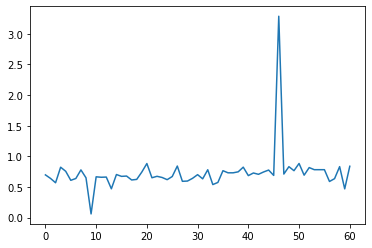

In [ ]:
data['ivol_mid'] = implied_volatility(price=data['close_option_usd'],
                                      S=data['close_spot'],
                                      K=strike,
                                      t=data['days_to_expiry']/365,
                                      r=r,
                                      flag=option_type, 
                                      return_as="series")
plt.plot(data['ivol_mid'])

In [ ]:
data[46:].head()

,volume_option,ticks,status_option,open_option,low_option,high_option,cost_option,close_option,volume_spot,status_spot,open_spot,low_spot,high_spot,cost_spot,close_spot,timestamp,close_option_usd,time_to_expiry,days_to_expiry,ivol_mid
46,185.7,1646784000000,ok,0.0490,0.0490,0.2870,14.34305,0.2870,43183.903993,ok,38740.5,38417.0,45378.0,1.793496e+09,41955.5,2022-03-09,12041.22850,16 days 08:00:00,16,3.286615
47,236.5,1646870400000,ok,0.2870,0.0385,0.2870,10.92120,0.0510,25751.476464,ok,41960.5,38452.5,42049.5,1.015279e+09,39425.5,2022-03-10,2010.70050,15 days 08:00:00,15,0.710316
48,62.9,1646956800000,ok,0.0425,0.0425,0.0515,3.02345,0.0510,13826.841135,ok,39425.0,38049.5,40683.5,5.398057e+08,38734.0,2022-03-11,1975.43400,14 days 08:00:00,14,0.830895
49,13.3,1647043200000,ok,0.0515,0.0445,0.0515,0.60235,0.0445,8764.888696,ok,38733.5,38238.0,40243.5,3.432222e+08,38806.5,2022-03-12,1726.88925,13 days 08:00:00,13,0.765322
50,17.3,1647129600000,ok,0.0440,0.0385,0.0440,0.75245,0.0405,7746.134677,ok,38805.0,37227.0,39727.0,3.001976e+08,37774.0,2022-03-13,1529.84700,12 days 08:00:00,12,0.883272


#### 4)b) Delta

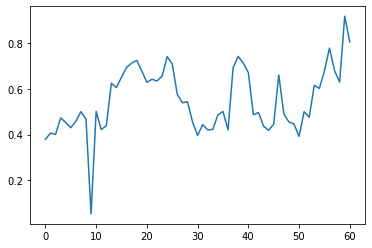

In [ ]:
data['delta_mid'] = py_vollib_vectorized.greeks.delta(option_type, data['close_spot'], strike,data['days_to_expiry']/365, r, data[ 'ivol_mid'])
plt.plot(data['delta_mid'])

#### 4)c) PnL

In [ ]:
data['daily_pnl_option'] = data['close_option_usd'].diff() * qty * mult
data["daily_pnl_spot"] = data['close_spot'].diff() * data['delta_mid'].shift() * qty * mult
ts = data['daily_pnl_option'] - data["daily_pnl_spot"] * is_delta_hedged
data['pnl'] = ts.cumsum()

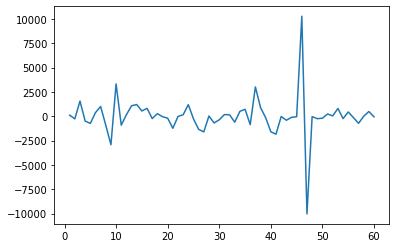

In [ ]:
plt.plot(data['daily_pnl_option'])

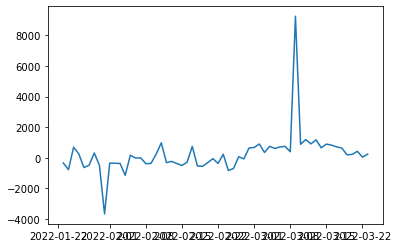

In [ ]:
plt.plot(data['timestamp'],data['pnl']);

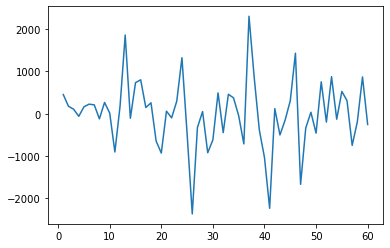

In [ ]:
plt.plot(data["daily_pnl_spot"])